# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [3]:
# Use this space for any additional import statements you need


In [2]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    # Place your Module 2 solution here
        # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
      # print the five most common tokens
        print("The five most common tokens are: ", Counter(tokens).most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [token for token in tokens if not token.lower() in sw]
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))


RE_TOKEN = re.compile(r"""
               ( [#]?[@\w'’\.\-\:]*\w     # words, hash tags and email adresses
               | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
               | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
               )
               """, re.VERBOSE)

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return RE_TOKEN.findall(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [3]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Module 2/Assignment_2/ads-tm-token-norm/M1 Assignment Data/M1 Results/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [4]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [5]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [6]:
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [7]:
# read in the lyrics here
artist_folders = os.listdir(data_location + lyrics_folder)

artist_lyrics_d = dict()

for artist in artist_folders :
    
    artist_lyrics_d[artist] = dict()
    
    artist_files = os.listdir(data_location + lyrics_folder + artist)
    
    for f_name in artist_files:
        
        # I stored the lyrics data in a dictionary with 
        # two dimensions of keys: artist and song. 
        # The value was the file contents. 
        with open(data_location + lyrics_folder + artist + "/" + f_name) as infile : 
            
            file_contents = infile.read()
            artist_lyrics_d[artist][f_name] = file_contents

In [8]:
#artist_lyrics_d

In [9]:
#create dataframe with filename, lyrics and artist for cher
filename_list = []
song_text_list = []

for k,v in artist_lyrics_d["cher"].items():
    filename_list.append(k)
    song_text_list.append(v)

data = {'filename': filename_list, 'lyrics': song_text_list}
lyrics_data = pd.DataFrame.from_dict(data)
lyrics_data['artist'] = "cher"

In [10]:
lyrics_data.head()

,filename,lyrics,artist
0,cher_88degrees.txt,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...",cher
1,cher_adifferentkindoflovesong.txt,"""A Different Kind Of Love Song""\n\n\n\nWhat if...",cher
2,cher_afterall.txt,"""After All""\n\n\n\nWell, here we are again\nI ...",cher
3,cher_again.txt,"""Again""\n\n\n\nAgain evening finds me at your ...",cher
4,cher_alfie.txt,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...",cher


In [11]:
#add the same data for artist "robyn", then add to the dataframe created above
filename_list = []
song_text_list = []

for k,v in artist_lyrics_d["robyn"].items():
    filename_list.append(k)
    song_text_list.append(v)
    
data_2 = {'filename': filename_list, 'lyrics': song_text_list}
lyrics_data_2 = pd.DataFrame.from_dict(data_2)

lyrics_data_2['artist'] = "robyn"

lyrics_data = pd.concat([lyrics_data, lyrics_data_2])
    
del(lyrics_data_2)

In [12]:
lyrics_data.head()

,filename,lyrics,artist
0,cher_88degrees.txt,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...",cher
1,cher_adifferentkindoflovesong.txt,"""A Different Kind Of Love Song""\n\n\n\nWhat if...",cher
2,cher_afterall.txt,"""After All""\n\n\n\nWell, here we are again\nI ...",cher
3,cher_again.txt,"""Again""\n\n\n\nAgain evening finds me at your ...",cher
4,cher_alfie.txt,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...",cher


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [13]:
#Remove song titles

#creates song title column, takes the song title from the lyric column
lyrics_data["song_title"] = lyrics_data["lyrics"].str.split("\n\n\n\n", expand=True)[0]

#deletes the song title from the lyrics column
lyrics_data["lyrics"] = lyrics_data["lyrics"].str.split("\n\n\n\n", expand=True)[1]

#removes the \n from the lyrics, replaces with ,
lyrics_data["lyrics"] = lyrics_data["lyrics"].str.replace("\n"," ")

In [14]:
lyrics_data.head()

,filename,lyrics,artist,song_title
0,cher_88degrees.txt,"Stuck in L.A., ain't got no friends And so Ho...",cher,"""88 Degrees"""
1,cher_adifferentkindoflovesong.txt,What if the world was crazy and I was sane Wou...,cher,"""A Different Kind Of Love Song"""
2,cher_afterall.txt,"Well, here we are again I guess it must be fat...",cher,"""After All"""
3,cher_again.txt,Again evening finds me at your door Here to a...,cher,"""Again"""
4,cher_alfie.txt,"What's it all about, Alfie? Is it just for the...",cher,"""Alfie"""


In [15]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [16]:
lyrics_data.head()

,filename,lyrics,artist,song_title,tokens,num_tokens
0,cher_88degrees.txt,"Stuck in L.A., ain't got no friends And so Ho...",cher,"""88 Degrees""","[stuck, la, aint, got, friends, hollywood, nut...",180
1,cher_adifferentkindoflovesong.txt,What if the world was crazy and I was sane Wou...,cher,"""A Different Kind Of Love Song""","[world, crazy, sane, would, strange, cant, bel...",133
2,cher_afterall.txt,"Well, here we are again I guess it must be fat...",cher,"""After All""","[well, guess, must, fate, weve, tried, deep, i...",120
3,cher_again.txt,Again evening finds me at your door Here to a...,cher,"""Again""","[evening, finds, door, ask, could, try, dont, ...",34
4,cher_alfie.txt,"What's it all about, Alfie? Is it just for the...",cher,"""Alfie""","[whats, alfie, moment, live, whats, sort, alfi...",66


In [17]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [18]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
410291,cher,I paint my own reality- Frida Kahlo✌️.....DOES...,"[paint, reality, frida, kahlo, doesn’t, everyo..."
1355243,cher,Democrat 🌊 He/him ♂️ Gay dude 🏳️‍🌈 German-Amer...,"[democrat, 🌊, hehim, gay, dude, 🏳, 🌈, germanam..."
1685366,cher,‏‏ الحمدلله.. 🙏,"[الحمدلله, 🙏]"
308929,cher,"Proud Resister, Fierce Ally 🌈 , Avid lover of ...","[proud, resister, fierce, ally, 🌈, avid, lover..."
997609,cher,she/they 🌈,"[shethey, 🌈]"
1126085,cher,Passion for custom fashion 🔫🔫🔫🔫,"[passion, custom, fashion, 🔫, 🔫, 🔫, 🔫]"
905958,cher,"#LoveisLove:♈ENFJ, friend, mentor, MA Human Ri...","[#loveislove, enfj, friend, mentor, human, rig..."
1552273,cher,☀️,[]
263386,cher,Into: IntelligenceBeautyTalentHumorKindness Fa...,"[intelligencebeautytalenthumorkindness, faithc..."
1300532,cher,📷☕🎞️🎥🎶,"[📷, 🎞, 🎥, 🎶]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: There are opportunities to improve domain specific tokenization using different libraries that focus on things like emojis (the umbrella emoji wasn't picked up), connected word abbreviations, or numerical expressions.  This becomes more important when you need much higher precision tokenization.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [19]:
# your code here

#create a list for the tokens in each lyric category, then apply the descriptive stats function
cher_tokens = []

for c in lyrics_data[lyrics_data['artist'] == "cher"]["tokens"]:
    
    cher_tokens.extend(c)
    
robyn_tokens = []

for r in lyrics_data[lyrics_data['artist'] == "robyn"]["tokens"]:
    
    robyn_tokens.extend(r)

In [20]:
descriptive_stats(cher_tokens, verbose=True)
descriptive_stats(robyn_tokens, verbose=True)

There are 35238 tokens in the data.
There are 3684 unique tokens in the data.
There are 169198 characters in the data.
The lexical diversity is 0.105 in the data.
The five most common tokens are:  [('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332)]
There are 15090 tokens in the data.
There are 2150 unique tokens in the data.
There are 72682 characters in the data.
The lexical diversity is 0.142 in the data.
The five most common tokens are:  [('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 250)]


[15090, 2150, 0.1424784625579854, 72682]

Q: what observations do you make about these data? 

A: There is a lot more data on Cher, and Robyn's lexical diversity is a little higher...however, they both have very similar common top tokens.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [21]:
# your code here
all_lyrics_tokens = list(set(cher_tokens + robyn_tokens) - {''})

n = 5

#********************
robyn_l_counts = []

for l_tok in all_lyrics_tokens:
    count = robyn_tokens.count(l_tok)
    robyn_l_counts.append(count)

#********************
cher_l_counts = []

for l_tok in all_lyrics_tokens:
    count = cher_tokens.count(l_tok)
    cher_l_counts.append(count)

In [22]:


comparison_df = pd.DataFrame({"Token": all_lyrics_tokens,
                              "cher_lyrics_count" : cher_l_counts, 
                              "robyn_lyrics_count" : robyn_l_counts})

# Calculating the concentration
comparison_df["Concentration_cher_lyrics"] =  comparison_df["cher_lyrics_count"] / len(cher_tokens)
comparison_df["Concentration_robyn_lyrics"] =  comparison_df["robyn_lyrics_count"] / len(robyn_tokens)


# Creating Passes cutoff column
comparison_df["Passes_cutoff"] = (comparison_df["cher_lyrics_count"] > n) & (comparison_df["robyn_lyrics_count"] > n)

# Creating Ratio column
# Very rare words can easily create infinite ratios!!
comparison_df["Ratio"] = comparison_df["Concentration_cher_lyrics"] / comparison_df["Concentration_robyn_lyrics"]

# Converting concentration values into Strings that show as percentages
comparison_df["Concentration_cher_lyrics"] = comparison_df["Concentration_cher_lyrics"].astype(float).map("{:.4%}".format)
comparison_df["Concentration_robyn_lyrics"] = comparison_df["Concentration_robyn_lyrics"].astype(float).map("{:.4%}".format)

# The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora
comparison_df[comparison_df["Passes_cutoff"] == True].sort_values(by=['Ratio'], ascending=False).head(10)



,Token,cher_lyrics_count,robyn_lyrics_count,Concentration_cher_lyrics,Concentration_robyn_lyrics,Passes_cutoff,Ratio
3755,find,135,6,0.3831%,0.0398%,True,9.635195
1160,enough,124,7,0.3519%,0.0464%,True,7.585804
543,man,201,12,0.5704%,0.0795%,True,7.172867
454,believe,139,11,0.3945%,0.0729%,True,5.411281
1715,well,163,16,0.4626%,0.1060%,True,4.362602
1668,hope,56,6,0.1589%,0.0398%,True,3.996822
4154,home,102,11,0.2895%,0.0729%,True,3.970868
1845,till,55,6,0.1561%,0.0398%,True,3.925450
1809,many,52,6,0.1476%,0.0398%,True,3.711334
2824,last,48,6,0.1362%,0.0398%,True,3.425847


In [23]:
#********* ALL TOKENS ********************************
# Create a Counter dictionary with ALL tokens
all_twitter_counter = Counter()
twitter_data["tokens"].map(all_twitter_counter.update)
# Drop missing values
del all_twitter_counter['nan']

# Set all values of Counter Dictionary to Zero
all_twitter_counter =  { x:0 for x in all_twitter_counter}

# Convert dictionary back to Counter
all_twitter_counter = Counter(all_twitter_counter)

# Create a list with all Tokens: all_twitter_tokens
all_twitter_tokens = list(all_twitter_counter.keys())

#********* Cher ********************************
# Update the Counter with only Cher's token counts
twitter_data[twitter_data["artist"] == "cher"]["tokens"].map(all_twitter_counter.update)
del all_twitter_counter['nan']

# Convert Cher's token counts into a list: cher_tw_counts
cher_tw_counts = list(all_twitter_counter.values())

#********* Robyn ********************************
# Set all values of Counter Dictionary Back to Zero
all_twitter_counter =  { x:0 for x in all_twitter_counter}
# Convert dictionary back to Counter
all_twitter_counter = Counter(all_twitter_counter)

# Update the Counter with only Robyn's token counts
twitter_data[twitter_data["artist"] == "robyn"]["tokens"].map(all_twitter_counter.update)
del all_twitter_counter['nan']

# Convert Robyn's token counts into a list: robyn_tw_counts
robyn_tw_counts = list(all_twitter_counter.values())



In [24]:
n = 5

comparison_tw_df = pd.DataFrame({"Token": all_twitter_tokens,
                              "cher_twitter_count" : cher_tw_counts, 
                              "robyn_twitter_count" : robyn_tw_counts})

# Calculating the concentration
comparison_tw_df["Concentration_cher_twitter"] =  comparison_tw_df["cher_twitter_count"] / len(cher_tw_counts)
comparison_tw_df["Concentration_robyn_twitter"] =  comparison_tw_df["robyn_twitter_count"] / len(robyn_tw_counts)


# Creating Passes cutoff column
comparison_tw_df["Passes_cutoff"] = (comparison_tw_df["cher_twitter_count"] > n) & (comparison_tw_df["robyn_twitter_count"] > n)

# Creating Ratio column
# Very rare words can easily create infinite ratios!!
comparison_tw_df["Ratio"] = comparison_tw_df["Concentration_cher_twitter"] / comparison_tw_df["Concentration_robyn_twitter"]

# Converting concentration values into Strings that show as percentages
comparison_tw_df["Concentration_cher_twitter"] = comparison_tw_df["Concentration_cher_twitter"].astype(float).map("{:.4%}".format)
comparison_tw_df["Concentration_robyn_twitter"] = comparison_tw_df["Concentration_robyn_twitter"].astype(float).map("{:.4%}".format)

# The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora
comparison_tw_df[comparison_tw_df["Passes_cutoff"] == True].sort_values(by=['Ratio'], ascending=False).head(10)



,Token,cher_twitter_count,robyn_twitter_count,Concentration_cher_twitter,Concentration_robyn_twitter,Passes_cutoff,Ratio
447,grandmother,7190,19,0.5294%,0.0014%,True,378.421053
1205,#fbr,3403,13,0.2506%,0.0010%,True,261.769231
997,nana,2068,9,0.1523%,0.0007%,True,229.777778
46702,rbsoul,1533,7,0.1129%,0.0005%,True,219.000000
933,resister,1941,9,0.1429%,0.0007%,True,215.666667
373,grandma,5836,29,0.4297%,0.0021%,True,201.241379
48,#theresistance,3500,18,0.2577%,0.0013%,True,194.444444
39004,hiphoprap,2480,13,0.1826%,0.0010%,True,190.769231
2707,#resistance,3039,16,0.2238%,0.0012%,True,189.937500
2995,gop,1319,7,0.0971%,0.0005%,True,188.428571


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: There's definitely something about referencing grandmothers...maybe it has to do with the age people are who enjoy these particular artists, and it reminds younger people of their grandmothers.  There is also some political references, suggesting the lyrics or artists may be the face of a movement.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [25]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, background_color= "black", colormap="Paired", max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [26]:
twitter_data = twitter_data.dropna(subset=["description"])
df_cher_twitter = twitter_data[twitter_data["artist"] == "cher"]
df_robyn_twitter = twitter_data[twitter_data["artist"] == "robyn"]
df_cher_lyrics = lyrics_data[lyrics_data["artist"] == "cher"]
df_robyn_lyrics = lyrics_data[lyrics_data["artist"] == "robyn"]

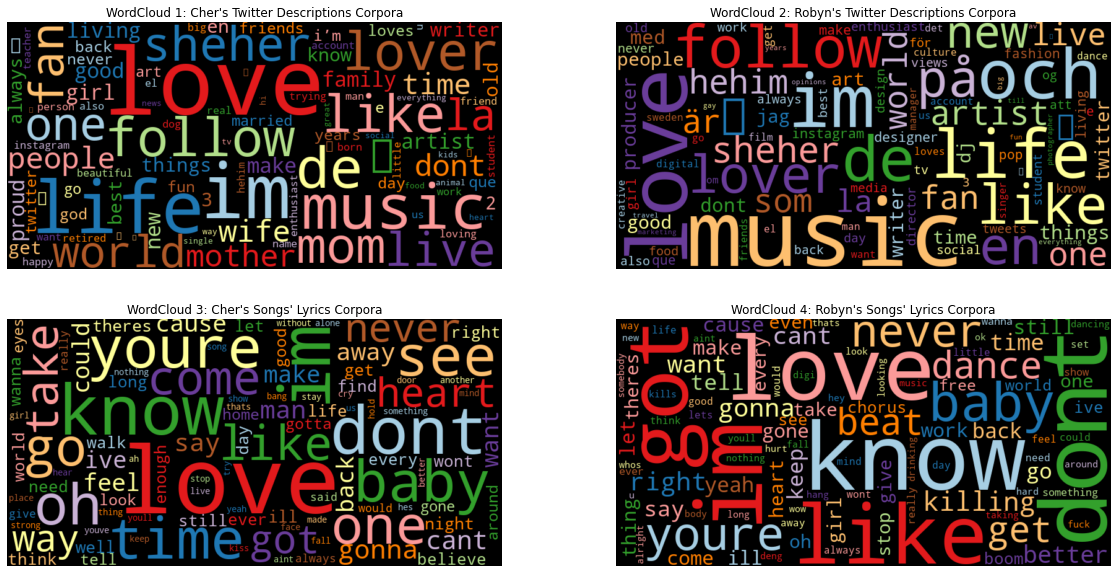

In [28]:
# Creating four WordClouds

plt.figure(figsize=(20,10))

# WordCloud 1 (Cher's Twitter Descriptions)
plt.subplot(2,2,1)
freq_tw_cher_df = count_words(df_cher_twitter)
wordcloud(freq_tw_cher_df['freq'], max_words=100)
plt.title("WordCloud 1: Cher's Twitter Descriptions Corpora")

# WordCloud 2 (Robyn's Twitter Descriptions)
plt.subplot(2,2,2)
freq_tw_robyn_df = count_words(df_robyn_twitter)
wordcloud(freq_tw_robyn_df['freq'], max_words=100)
plt.title("WordCloud 2: Robyn's Twitter Descriptions Corpora")

# WordCloud 3 (Cher's Lyrics)
plt.subplot(2,2,3)
freq_lyr_cher_df = count_words(df_cher_lyrics)
wordcloud(freq_lyr_cher_df['freq'], max_words=100)
plt.title("WordCloud 3: Cher's Songs' Lyrics Corpora")

# WordCloud 4 (Robyn's Lyrics)
plt.subplot(2,2,4)
freq_lyr_robyn_df = count_words(df_robyn_lyrics)
wordcloud(freq_lyr_robyn_df['freq'], max_words=100)
plt.title("WordCloud 4: Robyn's Songs' Lyrics Corpora")

plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The word love is prominent in all of the coproras, and they're lyrics tend to have very similar words, which I'm guessing may be common across lyrics in the same genre.